In [1]:
import ee 
import logging
import colorlog
from tqdm import tqdm
# import geemap
import os, datetime, requests, zipfile, time, math
import urllib.request
import datetime,math
import numpy as np
import subprocess as sub
import rasterio as rio
import geopandas as gpd
import pandas as pd
from pyproj import Proj, Transformer, CRS
from shapely.geometry import Polygon
from rasterio.mask import mask as riomask
import matplotlib.pyplot as plt
import configparser
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from shapely import wkt

import warnings
warnings.filterwarnings("ignore")

In [57]:
f = pd.read_csv('../Paper_Revision/Percolation/Percolation_20230101_20230430.csv')
f.dtypes

Date                  object
MeanSoilMoisture     float64
MeanPercolation      float64
MeanFieldCapacity    float64
RegionID              object
dtype: object

In [58]:
f['Date'] = pd.to_datetime(f['Date'], format = '%Y-%m-%d')
f.head()

,Date,MeanSoilMoisture,MeanPercolation,MeanFieldCapacity,RegionID
0,2023-01-04,0.304962,0.024501,0.313823,T1S1B_95
1,2023-01-07,0.652446,0.340397,0.313823,T1S1B_95
2,2023-01-11,0.648824,0.335995,0.313823,T1S1B_95
3,2023-01-16,0.290589,0.019735,0.313823,T1S1B_95
4,2023-01-19,0.627570,0.314044,0.313823,T1S1B_95


In [17]:
f = f[f['Date']<=pd.to_datetime('2023-04-30')].dropna().reset_index(drop = True)

In [18]:
f[f['RegionID'].str.contains(r'96$')].tail()

,Date,MeanSoilMoisture,MeanPercolation,MeanFieldCapacity,RegionID
3986,2023-04-13,0.555052,0.233018,0.320916,T6S7T_96
3987,2023-04-17,0.623567,0.301339,0.320916,T6S7T_96
3988,2023-04-22,0.219444,0.003728,0.320916,T6S7T_96
3989,2023-04-25,0.660080,0.338018,0.320916,T6S7T_96
3990,2023-04-29,0.663891,0.343244,0.320916,T6S7T_96


In [19]:
f = f.rename(columns = {'RegionID': 'CNLNM_ID'})


In [20]:
f["NormalizedSoilMoisture"] = f.groupby("CNLNM_ID")["MeanSoilMoisture"].transform(lambda x: (x.max() - x )/x.max())

# Step 2: Recalculate MeanPercolation using the formula max(0, MeanSoilMoisture - MeanFieldCapacity)
f["RecalculatedPercolation"] = f.apply(lambda row: max(0, row["MeanSoilMoisture"] - row["MeanFieldCapacity"]), axis=1)


In [21]:
f[f['CNLNM_ID'].str.contains(r'96$')].tail()

,Date,MeanSoilMoisture,MeanPercolation,MeanFieldCapacity,CNLNM_ID,NormalizedSoilMoisture,RecalculatedPercolation
3986,2023-04-13,0.555052,0.233018,0.320916,T6S7T_96,0.208564,0.234136
3987,2023-04-17,0.623567,0.301339,0.320916,T6S7T_96,0.110870,0.302651
3988,2023-04-22,0.219444,0.003728,0.320916,T6S7T_96,0.687100,0.000000
3989,2023-04-25,0.660080,0.338018,0.320916,T6S7T_96,0.058807,0.339164
3990,2023-04-29,0.663891,0.343244,0.320916,T6S7T_96,0.053373,0.342975


In [22]:
f[f['CNLNM_ID'].str.contains(r'96$')].describe()

,Date,MeanSoilMoisture,MeanPercolation,MeanFieldCapacity,NormalizedSoilMoisture,RecalculatedPercolation
count,26,26.000000,26.000000,2.600000e+01,26.000000,26.000000
mean,2023-02-28 04:36:55.384615424,0.501788,0.206001,3.209160e-01,0.284511,0.200601
min,2023-01-04 00:00:00,0.196740,0.001736,3.209160e-01,0.000000,0.000000
25%,2023-01-28 18:00:00,0.316390,0.042709,3.209160e-01,0.090087,0.020060
50%,2023-02-26 00:00:00,0.571702,0.252222,3.209160e-01,0.184822,0.250787
75%,2023-04-02 00:00:00,0.638143,0.316467,3.209160e-01,0.548867,0.317227
max,2023-04-29 00:00:00,0.701323,0.380341,3.209160e-01,0.719473,0.380407
std,NaN,0.174501,0.137882,5.661049e-17,0.248818,0.144240


In [23]:
(0.7 - 0.5)/(0.7)

0.28571428571428564

In [36]:
g = gpd.read_file('../TBP Shape Files/TCAD_Phase1_DataPartA/ShapeFiles/commandarea_teesta_ph1_simplified_modified_Irrigable_Area_Final.shp')
g.head()

,AREA,PERIMETER,ID,CNLNM,CNLSYS,AREA_HA,SEC_CNLNM,CNLNM_ID,Sec_CNLNM2,SEC_CNLNM3,SEC_CNLNM4,Area_HA_ro,Irrigable_,Irr_Area_F,areaAsset,areaFilter,ratio,Irrigable,Irrigabl_1,geometry
0,7086348.0,13762.490,1.0,Teesta Canal A,TEESTA,708.63,Teesta Canal A,Teesta_Canal_A_1,Teesta Canal A,Teesta Canal A,Teesta Canal A,709.0,414.602482,0.585076,710.538425,415.719056,0.585076,NaN,4.146025e+06,"POLYGON ((403794 892753.75, 403769.469 892781...."
1,6288421.0,12597.350,2.0,T1T,TEESTA,628.84,Teesta Canal A,T1T_2,Teesta Canal A,Teesta Canal A,Teesta Canal A,629.0,498.000000,0.791934,630.566085,518.787600,0.822733,498.0,4.980000e+06,"POLYGON ((402362.312 894209.875, 402441.75 894..."
2,19171620.0,29851.680,3.0,S1T,TEESTA,1917.16,Teesta Canal A,S1T_3,Teesta Canal A,Teesta Canal A,Teesta Canal A,1917.0,1547.000000,0.806923,1922.381433,1620.874403,0.843160,1547.0,1.547000e+07,"POLYGON ((403033.219 891642.5, 403161.719 8917..."
3,7156720.0,16715.580,4.0,Teesta Canal A,TEESTA,715.67,Teesta Canal A,Teesta_Canal_A_4,Teesta Canal A,Teesta Canal A,Teesta Canal A,716.0,603.057941,0.842648,717.577775,604.665524,0.842648,NaN,6.030579e+06,"POLYGON ((400392.5 891956.875, 400399.156 8919..."
4,3194351.0,7967.623,5.0,T1AT,TEESTA,319.44,Teesta Canal A,T1AT_5,Teesta Canal A,Teesta Canal A,Teesta Canal A,319.0,253.000000,0.792011,320.283452,268.401767,0.838013,253.0,2.530000e+06,"POLYGON ((403033.219 891642.5, 403068.781 8916..."


In [37]:
g = g[['CNLNM_ID','geometry']]

In [38]:
merged_gdf = g.merge(f,on = ['CNLNM_ID'])
merged_gdf.head()

,CNLNM_ID,geometry,Date,MeanSoilMoisture,MeanPercolation,MeanFieldCapacity,NormalizedSoilMoisture,RecalculatedPercolation
0,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-04,0.261090,0.009781,0.313697,0.667981,0.000000
1,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-07,0.680704,0.363005,0.313697,0.134371,0.367006
2,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-11,0.663430,0.356718,0.313697,0.156337,0.349733
3,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-16,0.246723,0.003843,0.313697,0.686250,0.000000
4,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-19,0.676544,0.363786,0.313697,0.139660,0.362847


In [39]:
len(merged_gdf), len(g), len(f)

(4471, 153, 4471)

In [40]:
merged_gdf.columns

Index(['CNLNM_ID', 'geometry', 'Date', 'MeanSoilMoisture', 'MeanPercolation',
       'MeanFieldCapacity', 'NormalizedSoilMoisture',
       'RecalculatedPercolation'],
      dtype='object')

In [42]:
merged_gdf[merged_gdf['CNLNM_ID' ]=='Teesta_Canal_A_1']

,CNLNM_ID,geometry,Date,MeanSoilMoisture,MeanPercolation,MeanFieldCapacity,NormalizedSoilMoisture,RecalculatedPercolation
0,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-04,0.261090,0.009781,0.313697,0.667981,0.000000
1,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-07,0.680704,0.363005,0.313697,0.134371,0.367006
2,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-11,0.663430,0.356718,0.313697,0.156337,0.349733
3,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-16,0.246723,0.003843,0.313697,0.686250,0.000000
4,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-19,0.676544,0.363786,0.313697,0.139660,0.362847
5,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-23,0.671904,0.358357,0.313697,0.145561,0.358206
6,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-28,0.265605,0.012781,0.313697,0.662238,0.000000
7,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-01-31,0.685806,0.381063,0.313697,0.127882,0.372109
8,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-02-04,0.586857,0.272892,0.313697,0.253712,0.273160
9,Teesta_Canal_A_1,"POLYGON ((403794 892753.75, 403769.469 892781....",2023-02-09,0.222657,0.001083,0.313697,0.716855,0.000000


In [ ]:
end_date = pd.to_datetime('2023-03-06')
start_date = end_date - pd.Timedelta(days=10)
merged_gdf = merged_gdf[(merged_gdf['Date'] >= start_date) & (merged_gdf['Date'] <= end_date)].dropna().reset_index(drop=True)
max_date = merged_gdf['Date'].max()
min_date = merged_gdf['Date'].min()
print(f'Max Date Observed: {max_date}, Min Date Observed: {min_date}')

Max Date Observed: 2023-03-05 00:00:00, Min Date Observed: 2023-02-24 00:00:00


In [49]:
mean_numeric = merged_gdf.groupby("CNLNM_ID").mean(numeric_only=True).reset_index()

# Add the geometry by taking the first occurrence per CNLNM_ID
geometry = merged_gdf.groupby("CNLNM_ID")["geometry"].first().reset_index()

# Merge the geometry with the mean numeric data
ground_water = pd.merge(geometry, mean_numeric, on="CNLNM_ID")

In [50]:
ground_water

,CNLNM_ID,geometry,MeanSoilMoisture,MeanPercolation,MeanFieldCapacity,NormalizedSoilMoisture,RecalculatedPercolation
0,Bogra_Canal_104,"POLYGON ((401364.625 856154.812, 401362.688 85...",0.538178,0.253998,0.285729,0.195348,0.252449
1,Bogra_Canal_78,"POLYGON ((401375.219 864771.25, 401439.344 864...",0.600557,0.307972,0.298895,0.149200,0.301662
2,Bogra_Canal_92,"POLYGON ((401703.594 861732.188, 401829.219 86...",0.572304,0.264352,0.312682,0.182443,0.259622
3,Dinajpur_Canal_123,"POLYGON ((382651.781 854189.062, 382638.156 85...",0.558773,0.267995,0.286303,0.169884,0.272470
4,Dinajpur_Canal_21,"POLYGON ((395732.812 883985.375, 395750.094 88...",0.562354,0.244392,0.326851,0.190776,0.235503
...,...,...,...,...,...,...,...
148,Teesta_Canal_A_13,"POLYGON ((397326.906 887453.75, 397507.406 887...",0.396707,0.127735,0.320448,0.460961,0.102272
149,Teesta_Canal_A_16,"POLYGON ((396396.406 886467.5, 396626.562 8867...",0.447299,0.161411,0.318593,0.442017,0.149077
150,Teesta_Canal_A_4,"POLYGON ((400392.5 891956.875, 400399.156 8919...",0.618129,0.297368,0.326347,0.150466,0.291782
151,Teesta_Canal_B_18,"POLYGON ((398088.094 885636.812, 398110.562 88...",0.544940,0.237136,0.321758,0.216071,0.223182


In [29]:
merged_gdf.dtypes
# merged_gdf = merged_gdf[['AREA','ID','CNLNM_ID','Area_HA_ro','Irrigable_','Irr_Area_F','Irrigabl_1', 'Date', 'MeanSoilMoisture','MeanFieldCapacity', 'MeanPercolation']]

AREA                              float64
PERIMETER                         float64
ID                                float64
CNLNM                              object
CNLSYS                             object
AREA_HA                           float64
SEC_CNLNM                          object
CNLNM_ID                           object
Sec_CNLNM2                         object
SEC_CNLNM3                         object
SEC_CNLNM4                         object
Area_HA_ro                        float64
Irrigable_                        float64
Irr_Area_F                        float64
areaAsset                         float64
areaFilter                        float64
ratio                             float64
 Irrigable                        float64
Irrigabl_1                        float64
geometry                         geometry
Date                       datetime64[ns]
MeanSoilMoisture                  float64
MeanPercolation                   float64
MeanFieldCapacity                 

In [33]:
merged_gdf.isna().sum()

AREA                          0
PERIMETER                     0
ID                            0
CNLNM                         0
CNLSYS                       36
AREA_HA                       0
SEC_CNLNM                     0
CNLNM_ID                      0
Sec_CNLNM2                    0
SEC_CNLNM3                    0
SEC_CNLNM4                    0
Area_HA_ro                    0
Irrigable_                    0
Irr_Area_F                    0
areaAsset                     0
areaFilter                    0
ratio                         0
 Irrigable                 1183
Irrigabl_1                    0
geometry                      0
Date                          0
MeanSoilMoisture              0
MeanPercolation               0
MeanFieldCapacity             0
NormalizedSoilMoisture        0
RecalculatedPercolation       0
dtype: int64

In [30]:
# merged_gdf_percolation_grouped = merged_gdf.groupby(by = 'CNLNM_ID').mean().reset_index()
# merged_gdf_percolation_grouped['geometry'] = merged_gdf_percolation_grouped.merge(merged_gdf, on = 'geometry')

In [31]:
# merged_gdf_percolation_grouped.reset_index()

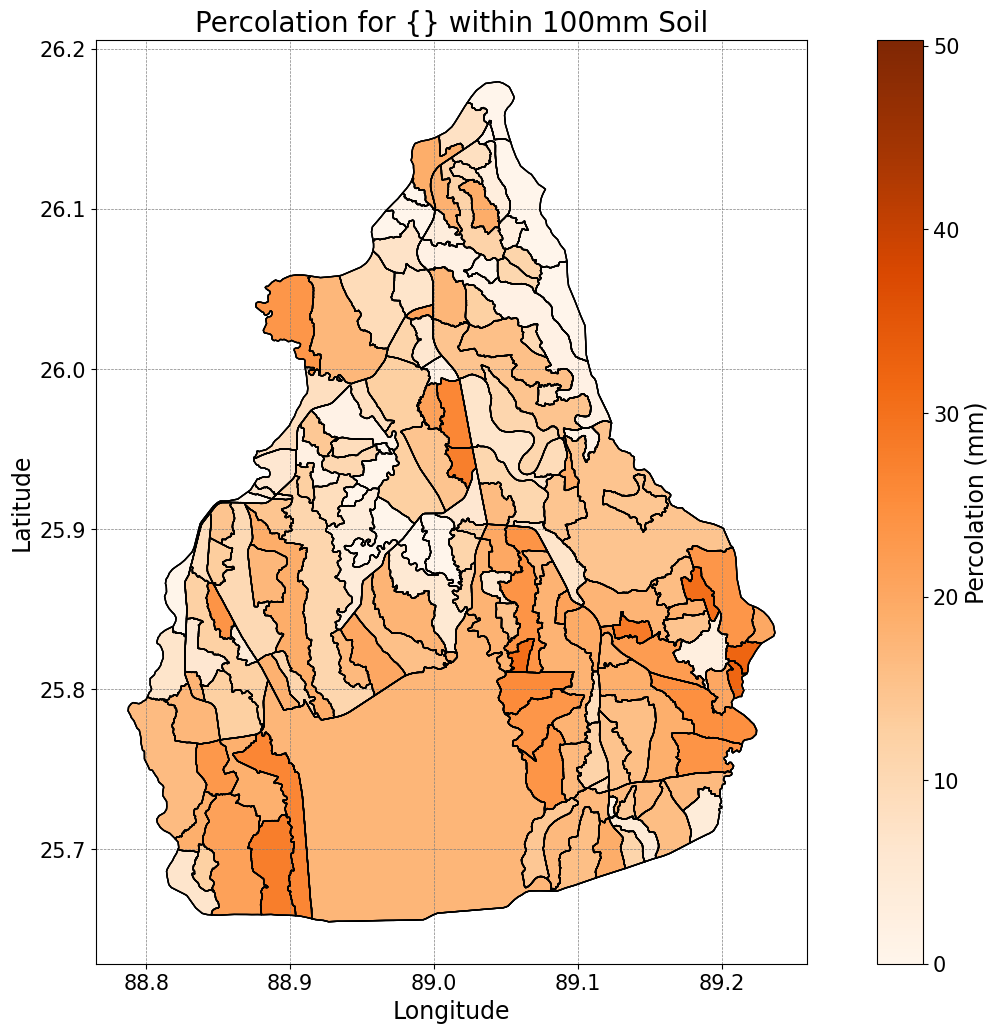

In [ ]:
# data['geometry'] = data['geometry'].apply(wkt.loads)
# gdf = merged_gdf_percolation_grouped
gdf = merged_gdf
# Set CRS
btm_proj4 = '+proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +ellps=evrst30 +units=m +no_defs +type=crs'
gdf.set_crs(btm_proj4, inplace=True, allow_override=True)
gdf = gdf.to_crs("EPSG:4326")

# Convert 'net_water_req (m3)' to numeric and take absolute values
interested_variable = 'NormalizedSoilMoisture'
gdf[interested_variable] = pd.to_numeric(gdf[interested_variable], errors='coerce').abs()

# Multiplying with the root depth (constrained with Sentinel 1 depth, 100mm)
gdf[f'{interested_variable} (100mm)'] = gdf[interested_variable] * 100 

# Function to lighten colormap
def lighten_colormap(cmap, lightness_factor=0.5):
    cmap_colors = cmap(np.linspace(0, 1, cmap.N))
    white = np.ones((cmap.N, 4))
    lightened_colors = (1 - lightness_factor) * cmap_colors + lightness_factor * white
    return ListedColormap(lightened_colors)

# Lighten the viridis colormap
lightness_factor = 0  # Change this value to adjust the lightness (0.0 to 1.0)
lightened_viridis = lighten_colormap(plt.get_cmap('Oranges'), lightness_factor)

# Create a normalized color scale
norm = mcolors.Normalize(vmin=gdf[f'{interested_variable} (100mm)'].min(), vmax=gdf[f'{interested_variable} (100mm)'].max())

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
gdf.boundary.plot(ax=ax, linewidth=1, color='black')  # Plot boundaries for better visualization
gdf.plot(column=f'{interested_variable} (100mm)', cmap=lightened_viridis, linewidth=0.8, ax=ax, edgecolor='0.8', norm=norm)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=lightened_viridis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Percolation (mm)',fontsize = 17)
cbar.ax.tick_params(axis = 'both',labelsize=15) 
# Add title and labels
ax.set_title('Percolation for {} within 100mm Soil',fontsize = 20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax.tick_params(axis = 'x',colors = 'black', labelsize = 15)
ax.tick_params(axis = 'y',colors = 'black', labelsize = 15)
ax.set_xlabel("Longitude", fontsize=17, color='black')
ax.set_ylabel("Latitude", fontsize=17, color='black')
# Show the plot
plt.show()


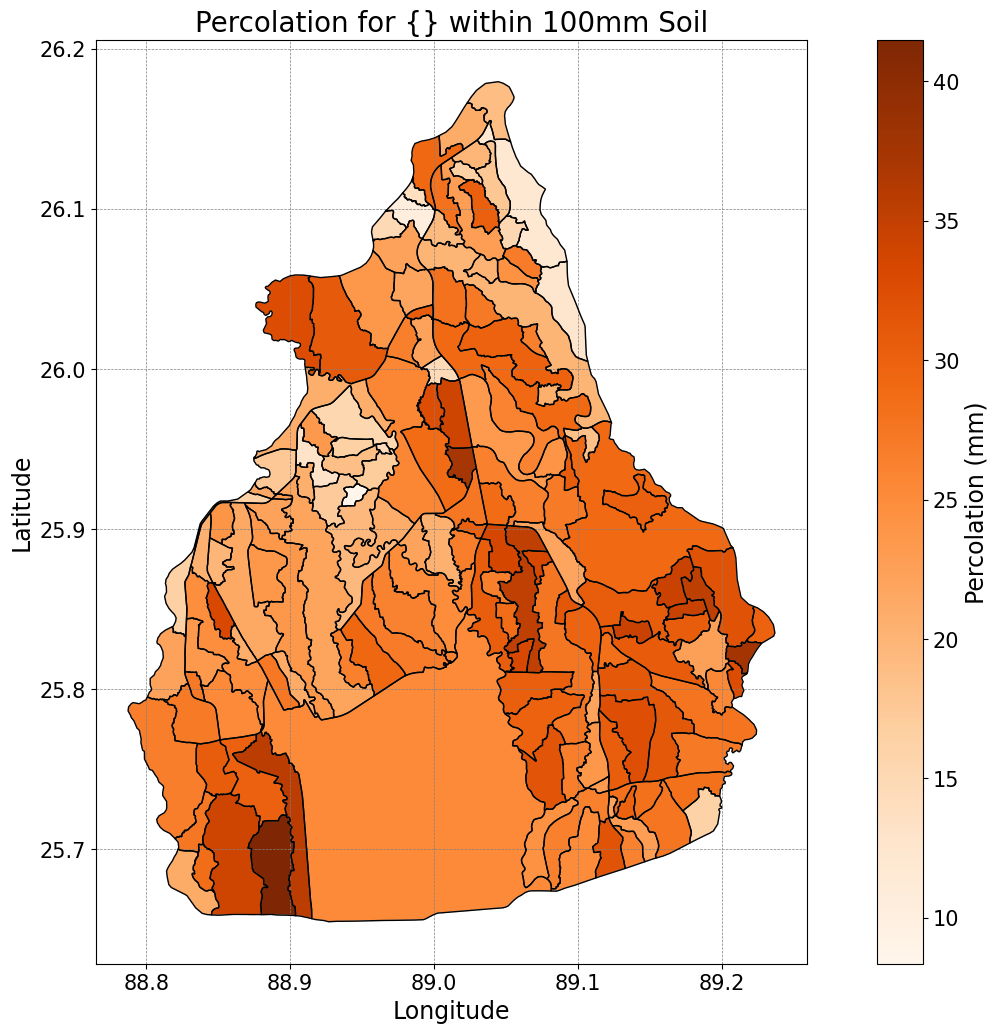

In [54]:
# data['geometry'] = data['geometry'].apply(wkt.loads)
# gdf = merged_gdf_percolation_grouped
gdf = ground_water
# Set CRS
btm_proj4 = '+proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +ellps=evrst30 +units=m +no_defs +type=crs'
gdf.set_crs(btm_proj4, inplace=True, allow_override=True)
gdf = gdf.to_crs("EPSG:4326")

# Convert 'net_water_req (m3)' to numeric and take absolute values
interested_variable = 'RecalculatedPercolation'
gdf[interested_variable] = pd.to_numeric(gdf[interested_variable], errors='coerce').abs()

# Multiplying with the root depth (constrained with Sentinel 1 depth, 100mm)
gdf[f'{interested_variable} (100mm)'] = gdf[interested_variable] * 100 

# Function to lighten colormap
def lighten_colormap(cmap, lightness_factor=0.5):
    cmap_colors = cmap(np.linspace(0, 1, cmap.N))
    white = np.ones((cmap.N, 4))
    lightened_colors = (1 - lightness_factor) * cmap_colors + lightness_factor * white
    return ListedColormap(lightened_colors)

# Lighten the viridis colormap
lightness_factor = 0  # Change this value to adjust the lightness (0.0 to 1.0)
lightened_viridis = lighten_colormap(plt.get_cmap('Oranges'), lightness_factor)

# Create a normalized color scale
norm = mcolors.Normalize(vmin=gdf[f'{interested_variable} (100mm)'].min(), vmax=gdf[f'{interested_variable} (100mm)'].max())

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
gdf.boundary.plot(ax=ax, linewidth=1, color='black')  # Plot boundaries for better visualization
gdf.plot(column=f'{interested_variable} (100mm)', cmap=lightened_viridis, linewidth=0.8, ax=ax, edgecolor='0.8', norm=norm)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=lightened_viridis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Percolation (mm)',fontsize = 17)
cbar.ax.tick_params(axis = 'both',labelsize=15) 
# Add title and labels
ax.set_title('Percolation for {} within 100mm Soil',fontsize = 20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax.tick_params(axis = 'x',colors = 'black', labelsize = 15)
ax.tick_params(axis = 'y',colors = 'black', labelsize = 15)
ax.set_xlabel("Longitude", fontsize=17, color='black')
ax.set_ylabel("Latitude", fontsize=17, color='black')
# Show the plot
plt.show()


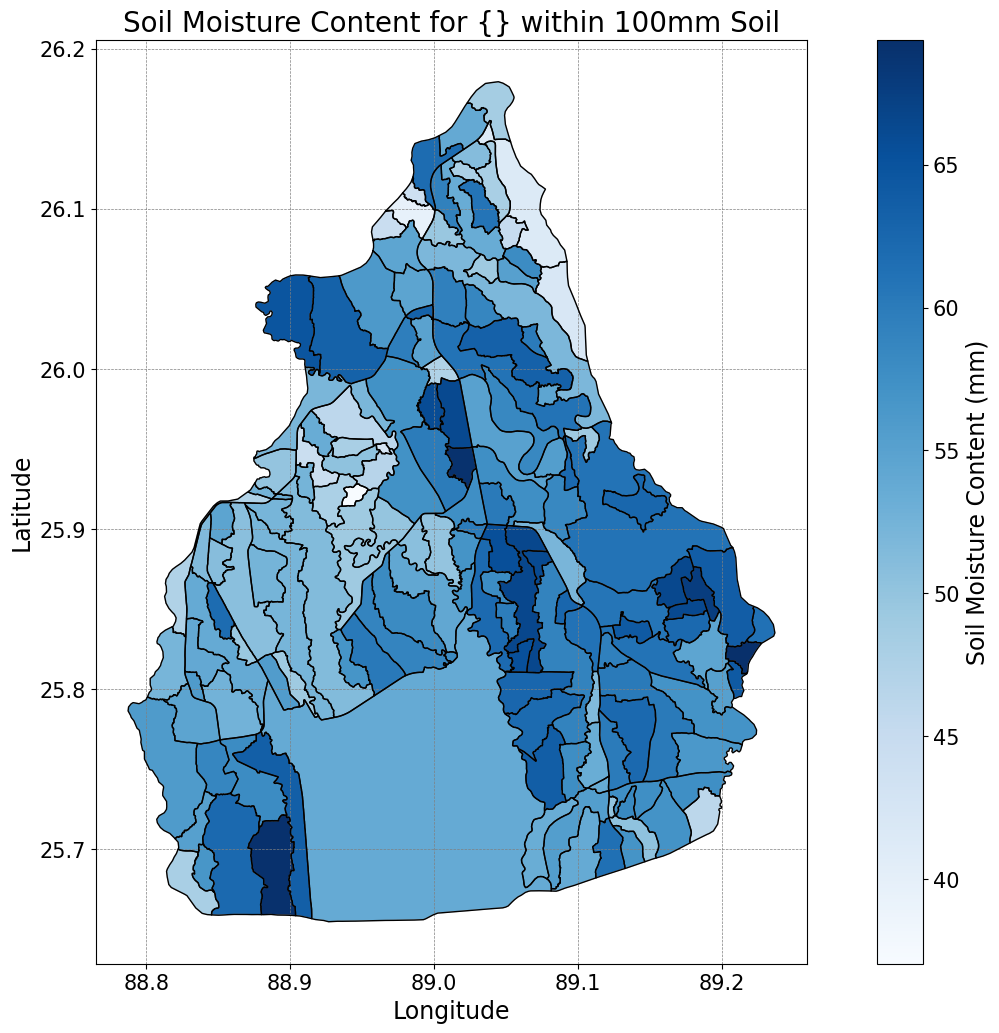

In [55]:
# data['geometry'] = data['geometry'].apply(wkt.loads)
# gdf = merged_gdf_percolation_grouped
gdf = ground_water
# Set CRS
btm_proj4 = '+proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +ellps=evrst30 +units=m +no_defs +type=crs'
gdf.set_crs(btm_proj4, inplace=True, allow_override=True)
gdf = gdf.to_crs("EPSG:4326")

# Convert 'net_water_req (m3)' to numeric and take absolute values
gdf['MeanSoilMoisture'] = pd.to_numeric(gdf['MeanSoilMoisture'], errors='coerce').abs()

# Multiplying with the root depth (constrained with Sentinel 1 depth, 100mm)
gdf['MeanSoilMoisture (100mm)'] = gdf['MeanSoilMoisture'] * 100 

# Function to lighten colormap
def lighten_colormap(cmap, lightness_factor=0.5):
    cmap_colors = cmap(np.linspace(0, 1, cmap.N))
    white = np.ones((cmap.N, 4))
    lightened_colors = (1 - lightness_factor) * cmap_colors + lightness_factor * white
    return ListedColormap(lightened_colors)

# Lighten the viridis colormap
lightness_factor = 0  # Change this value to adjust the lightness (0.0 to 1.0)
lightened_viridis = lighten_colormap(plt.get_cmap('Blues'), lightness_factor)

# Create a normalized color scale
norm = mcolors.Normalize(vmin=gdf['MeanSoilMoisture (100mm)'].min(), vmax=gdf['MeanSoilMoisture (100mm)'].max())

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
gdf.boundary.plot(ax=ax, linewidth=1, color='black')  # Plot boundaries for better visualization
gdf.plot(column='MeanSoilMoisture (100mm)', cmap=lightened_viridis, linewidth=0.8, ax=ax, edgecolor='0.8', norm=norm)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=lightened_viridis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Soil Moisture Content (mm)',fontsize = 17)
cbar.ax.tick_params(axis = 'both',labelsize=15) 
# Add title and labels
ax.set_title('Soil Moisture Content for {} within 100mm Soil',fontsize = 20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax.tick_params(axis = 'x',colors = 'black', labelsize = 15)
ax.tick_params(axis = 'y',colors = 'black', labelsize = 15)
ax.set_xlabel("Longitude", fontsize=17, color='black')
ax.set_ylabel("Latitude", fontsize=17, color='black')
# Show the plot
plt.show()


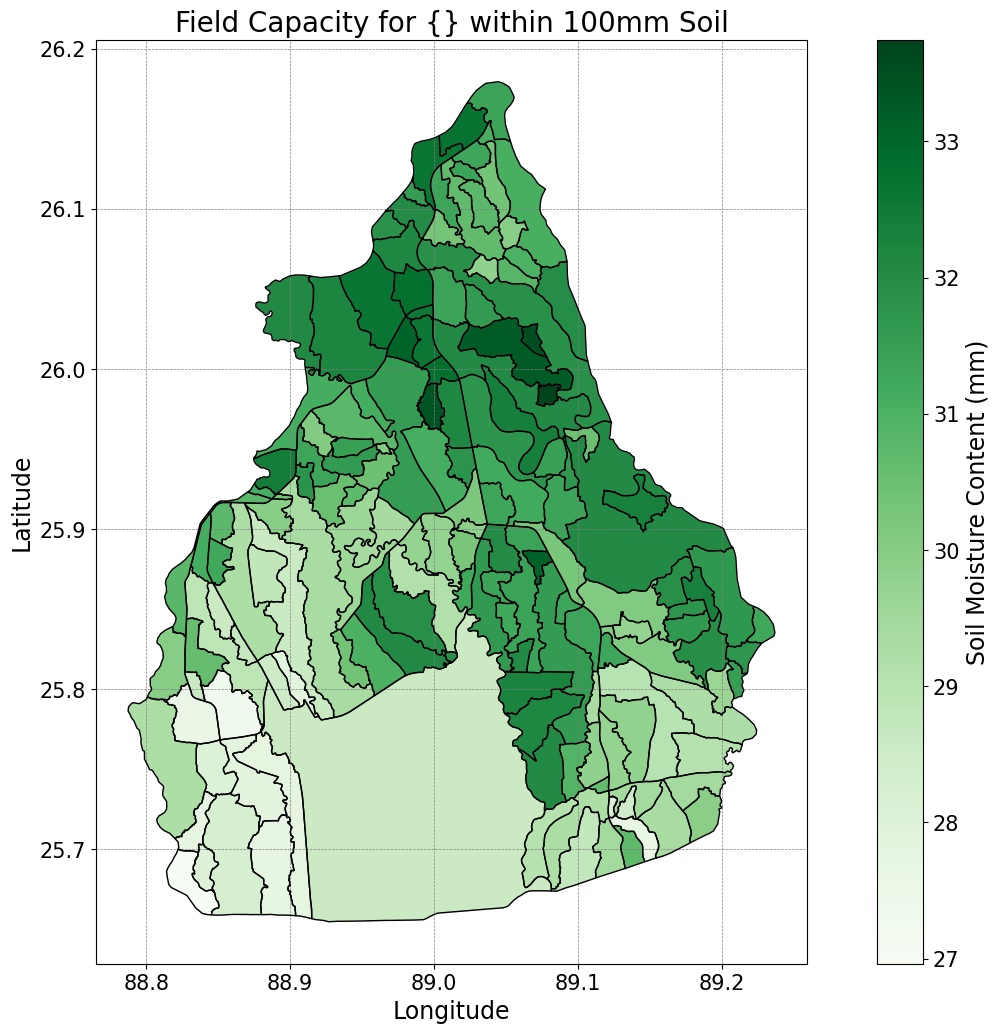

In [56]:
# data['geometry'] = data['geometry'].apply(wkt.loads)
# gdf = merged_gdf_percolation_grouped
gdf = ground_water
# Set CRS
btm_proj4 = '+proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +ellps=evrst30 +units=m +no_defs +type=crs'
gdf.set_crs(btm_proj4, inplace=True, allow_override=True)
gdf = gdf.to_crs("EPSG:4326")

# Convert 'net_water_req (m3)' to numeric and take absolute values
gdf['MeanFieldCapacity'] = pd.to_numeric(gdf['MeanFieldCapacity'], errors='coerce').abs()

# Multiplying with the root depth (constrained with Sentinel 1 depth, 100mm)
gdf['MeanFieldCapacity (100mm)'] = gdf['MeanFieldCapacity'] * 100 

# Function to lighten colormap
def lighten_colormap(cmap, lightness_factor=0.5):
    cmap_colors = cmap(np.linspace(0, 1, cmap.N))
    white = np.ones((cmap.N, 4))
    lightened_colors = (1 - lightness_factor) * cmap_colors + lightness_factor * white
    return ListedColormap(lightened_colors)

# Lighten the viridis colormap
lightness_factor = 0  # Change this value to adjust the lightness (0.0 to 1.0)
lightened_viridis = lighten_colormap(plt.get_cmap('Greens'), lightness_factor)

# Create a normalized color scale
norm = mcolors.Normalize(vmin=gdf['MeanFieldCapacity (100mm)'].min(), vmax=gdf['MeanFieldCapacity (100mm)'].max())

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
gdf.boundary.plot(ax=ax, linewidth=1, color='black')  # Plot boundaries for better visualization
gdf.plot(column='MeanFieldCapacity (100mm)', cmap=lightened_viridis, linewidth=0.8, ax=ax, edgecolor='0.8', norm=norm)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=lightened_viridis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Soil Moisture Content (mm)',fontsize = 17)
cbar.ax.tick_params(axis = 'both',labelsize=15) 
# Add title and labels
ax.set_title('Field Capacity for {} within 100mm Soil',fontsize = 20)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
ax.tick_params(axis = 'x',colors = 'black', labelsize = 15)
ax.tick_params(axis = 'y',colors = 'black', labelsize = 15)
ax.set_xlabel("Longitude", fontsize=17, color='black')
ax.set_ylabel("Latitude", fontsize=17, color='black')
# Show the plot
plt.show()
